# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../rec_data/retail_train.csv')
item_features = pd.read_csv('../rec_data/product.csv')
user_features = pd.read_csv('../rec_data/hh_demographic.csv')

In [3]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
common_users = data_train_lvl_1.user_id.values
data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]


In [6]:
%%time
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

Wall time: 5.81 s


In [7]:
recommender.get_als_recommendations(2375, N=5)

[899624, 871756, 1044078, 1106523, 844179]

In [8]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 844179, 1078652, 15778319]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 1096573, 835351, 861494, 821741]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [11]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()

In [12]:
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(3)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67..."


In [13]:
def calc_recall(dataframe, top_k=50):
    for col_name in dataframe.columns[2:]:
        yield col_name, dataframe.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()
        
def calc_precision(dataframe, top_k=50):
    for col_name in dataframe.columns[2:]:
        yield col_name, dataframe.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()

In [14]:
%%time
result_lvl_1['own_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 50))


Wall time: 9.91 s


In [15]:
%%time
result_lvl_1['item_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, 50))

Wall time: 14.5 s


In [16]:
%%time
result_lvl_1['user_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, 50))

Wall time: 7min 55s


In [17]:
%%time
result_lvl_1['als_rec'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 50))

Wall time: 18.1 s


In [20]:
recall_array = list()
for col in result_lvl_1.iloc[:,2:]:
    print(col, end=': ')
    recall_array.append(result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=50), axis=1).mean())
    print(recall_arr[-1])

own_rec: 0.06525657038145175
item_rec: 0.03440003909773267
user_rec: 0.007161268776648922
als_rec: 0.04696669791877576


**Лучший результат Recall дает get_own_recommendations**

**B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}**

In [21]:
%%time
recall_list =[]
for k in [50, 100, 200, 250, 300, 500]:
    result_lvl_1[f'own_{k}'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=k))
    
    recall_list.append(result_lvl_1.apply(lambda row: recall_at_k(row[f'own_{k}'], row['actual'], k=k), axis=1).mean())

Wall time: 1min 1s


In [22]:
recall_list

[0.06525657038145175,
 0.09604492955885034,
 0.13537278412833242,
 0.14794496163342993,
 0.15718418800895068,
 0.18205324555508678]

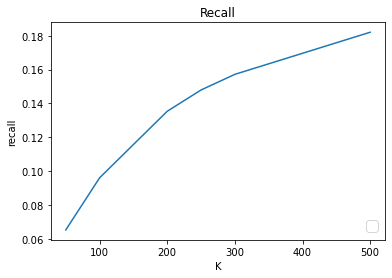

In [23]:
plt.plot([50, 100, 200, 250, 300, 500], recall_list)

plt.xlabel('K')
plt.ylabel('recall')
plt.title('Recall')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

**Recall растет от увеличения К**

**own recommendtions + top-popular дают лучший Recall**

**C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?**

Ответ: Думаю разумным будет число не более 20 даже это при том что при росте К растет Recall, но при этом будет падать точность Precision, да большее колличество рекомендаций просто утомит пользователя при их просмотре.

### Задание 2.

Обучите модель 2-ого уровня, при этом:

    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [24]:
#precision lvl1
result_lvl_1[f'own_5'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, 5))
precision_lvl1=result_lvl_1.apply(lambda row: precision_at_k(row[f'own_5'], row['actual'], k=5), axis=1).mean()


In [25]:
data_train_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


In [26]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [27]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [28]:
X_train = data_train_lvl_2.merge(item_features, on='item_id', how='left')
X_train = X_train.merge(user_features, on='user_id', how='left')

In [29]:
X_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,...,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
%%time
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))


In [31]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})
# тут только горячий старт
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 
targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
targets_lvl_2['target'].fillna(0, inplace= True)

targets_lvl_2

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0
2,2070,879194,0.0
3,2070,948640,0.0
4,2070,928263,0.0
...,...,...,...
111308,1745,903454,0.0
111309,1745,9419888,0.0
111310,1745,1076769,0.0
111311,1745,1092588,0.0


In [32]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


In [33]:
# добавляем фичи

#средний чек
average_check = data_train_lvl_2.groupby(['user_id', 'basket_id'], as_index=False)['sales_value'].sum()
average_check = average_check.groupby('user_id', as_index=False).mean()
average_check = average_check.drop('basket_id', axis=1)
average_check.rename(columns={'sales_value': 'average_check'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(average_check, on='user_id', how='left')

#колво покупок
num_pur = data_train_lvl_2.merge(item_features, on='item_id', how='left')
num_pur = num_pur.groupby(['user_id', 'department'], as_index=False)['quantity'].sum()
num_pur.rename(columns={'quantity': 'num_pur'}, inplace=True)
num_pur['num_pur'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(num_pur, on=['user_id', 'department'], how='left')

#серддняя цена
price = data.loc[:,('item_id', 'quantity', 'sales_value')]
price = price.groupby('item_id', as_index=False)[['quantity', 'sales_value']].sum()
price['price'] = price['sales_value'] / price['quantity']
price = price.drop(['quantity', 'sales_value'], axis=1)
targets_lvl_2 = targets_lvl_2.merge(price, on='item_id', how='left')

#лучшие недели
goods_per_week = data_train_lvl_2.groupby(['item_id', 'week_no'], as_index=False)['quantity'].sum()
goods_per_week = goods_per_week.groupby('item_id', as_index=False)['quantity'].mean()
goods_per_week.rename(columns={'quantity': 'goods_per_week'}, inplace=True)
goods_per_week['goods_per_week'].fillna(0, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(goods_per_week, on='item_id', how='left')


In [34]:
X_train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,...,SOFT DRINKS,SOFT DRINK BOTTLE NON-CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,...,EGGS,EGGS - LARGE,1 DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,...,CANNED JUICES,FRUIT DRINKS: CANNED & GLASS (,128 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [36]:
cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'average_check',
 'num_pur',
 'price',
 'goods_per_week']

### обучим модель ###

In [37]:
%%time
lgb = LGBMClassifier(objective='binary', max_depth=15, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict_proba(X_train)

In [38]:
train_preds

array([[0.96034247, 0.03965753],
       [0.97801656, 0.02198344],
       [0.94948147, 0.05051853],
       ...,
       [0.93320965, 0.06679035],
       [0.84920695, 0.15079305],
       [0.89644139, 0.10355861]])

In [39]:
data_val_lvl_2.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2277416,338,41260573635,636,840173,1,1.99,369,0.0,112,92,0.0,0.0
2277417,338,41260573635,636,1037348,1,0.89,369,-0.3,112,92,0.0,0.0


In [40]:
preds = train_preds[:,1]

In [41]:
preds

array([0.03965753, 0.02198344, 0.05051853, ..., 0.06679035, 0.15079305,
       0.10355861])

In [42]:
targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,num_pur,price,goods_per_week
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,3.0,3.905593,1.666667
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,213.0,11.471481,1.000000
2,2070,879194,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,14 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,31.0,7.237222,NaN
3,2070,948640,0.0,1213,DRUG GM,National,ORAL HYGIENE PRODUCTS,WHITENING SYSTEMS,3 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,31.0,6.596122,NaN
4,2070,928263,0.0,69,DRUG GM,Private,DIAPERS & DISPOSABLES,BABY DIAPERS,13 CT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,31.0,7.632459,2.200000


In [43]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [44]:
targets_lvl_2['pred'] = preds
targets_lvl_2 = targets_lvl_2.sort_values(['user_id', 'pred'], ascending=[False, False])
targets_lvl_2

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,average_check,num_pur,price,goods_per_week,pred
72056,2500,1086061,0.0,1046,GROCERY,National,COFFEE,GROUND COFFEE,34.5 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,5.656282,3.250000,0.159561
72061,2500,5572308,0.0,1280,NUTRITION,National,REFRIGERATED,YOGURT,24 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,6.0,3.117800,1.500000,0.131252
72072,2500,9677874,0.0,531,GROCERY,National,CANNED JUICES,BLENDED JUICE&COMBINATIONS (OV,64 OZ PET,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,2.291203,3.000000,0.125135
72093,2500,6534030,0.0,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,3.026368,2.666667,0.118710
72058,2500,1065538,1.0,239,GROCERY,National,BEERS/ALES,BEERALEMALT LIQUORS,12OZ,NaN,...,NaN,NaN,NaN,NaN,NaN,41.700000,84.0,15.771750,2.666667,0.089880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46164,1,1088462,0.0,69,DELI,Private,CHEESES,CHEESE: NATURAL PREPORTND,8 OZ,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,4.0,3.245625,1.000000,0.141081
46192,1,7152319,0.0,2627,GROCERY,National,DOMESTIC WINE,POPULAR 750ML WINES,4/187 ML,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,103.0,6.901111,NaN,0.127331
46203,1,7431134,0.0,523,PASTRY,National,PIES,PIES: FRUIT/NUT,,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,4.0,3.628103,1.000000,0.082896
46199,1,979674,0.0,111,DRUG GM,National,CIGARETTES,CIGARETTES,CTN,65+,...,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,48.825714,13.0,35.840000,1.200000,0.058035


In [45]:
preds_lgbm = targets_lvl_2[['user_id', 'item_id']].copy().drop_duplicates()
preds_lgbm = preds_lgbm.groupby('user_id')['item_id'].apply(list).reset_index()
preds_lgbm['item_id'] = preds_lgbm.apply(lambda row: row['item_id'][:5], axis=1)
preds_lgbm

,user_id,item_id
0,1,"[9527558, 8293439, 9655212, 856942, 898121]"
1,2,"[898847, 1110244, 907099, 862725, 5567582]"
2,4,"[883932, 908283, 1079528, 5568447, 1115098]"
3,6,"[900802, 1098844, 12757544, 1098284, 878715]"
4,7,"[1122358, 9338009, 990897, 1010051, 983316]"
...,...,...
2146,2496,"[1056509, 1056267, 5591083, 865511, 1069003]"
2147,2497,"[1135834, 1050741, 1138292, 849202, 951164]"
2148,2498,"[849578, 5576075, 9837092, 994223, 1022066]"
2149,2499,"[889989, 901460, 1015280, 6904613, 1060872]"


In [46]:
result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result.rename(columns={'item_id': 'actual'}, inplace=True)
result = result[result['user_id'].isin(train_users)]

result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [47]:
result = result.merge(preds_lgbm, on='user_id', how='left')
result.rename(columns={'item_id': 'lgb'}, inplace=True)

result.head(2)

,user_id,actual,lgb
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[9527558, 8293439, 9655212, 856942, 898121]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...",NaN


In [48]:
result = result[result['lgb'].notna()]

In [50]:
#precision lvl2
precision_lvl2 = result.apply(lambda row: precision_at_k(row['lgb'], row['actual'], k=5), axis=1).mean()

In [54]:
print(f'Precision lvl1 = {precision_lvl1}\nPrecision lvl2 = {precision_lvl2}')

Precision lvl1 = 0.17712691771268974
Precision lvl2 = 0.18454308093994612


***precision@5 вырос при использовании двухуровневой модели***